Importing the required libraries.

In [27]:
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np
import pdb
import matplotlib.pyplot as plt
import seaborn as sns

A function to list all files in a given directory, as it will be useful later on.

In [28]:
def list_files(path):
    return [o for o in path.iterdir()]

# Data Analysis

In [29]:
path = Path('input')
img_size = 256
bs = 16
train_filenames = list_files(path/'train')
train = pd.read_csv(path/'train.csv')
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


Here, we get an idea of train.csv and the information it provides. Since the patient's sex, age, and area of the lesion are provided, we must ask these questions in the web app and train the model based on these parameters. There is also the 'unknown' diagnosis, which will correspond to not having any form of malignant skin disease.

In [30]:
test = pd.read_csv(path/'test.csv')

train.shape, test.shape

((33126, 11), (10982, 7))

There are approximately 33k train images and 11k test images, making the train-test split equal to 75:25.

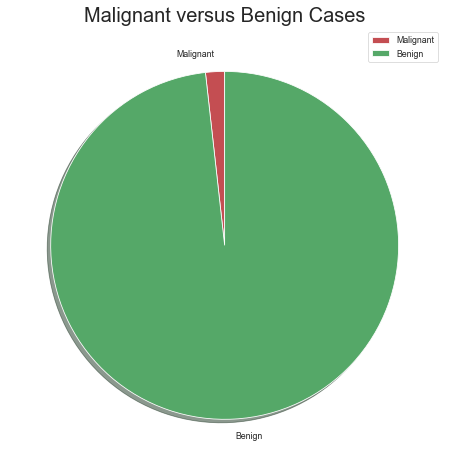

In [31]:
malignant = len(train[train["target"] == 1])
benign = len(train[train["target"] == 0])

labels = ["Malignant", "Benign"] 
size = [malignant, benign]

plt.figure(figsize = (8, 8))
plt.pie(size, labels = labels, shadow = True, startangle = 90, colors = ["r", "g"])
plt.title("Malignant versus Benign Cases")
plt.legend()

This indicates that the datapase is highly imbalanced. Now let us check if there is any correlation between gender and melanoma.

## Gender

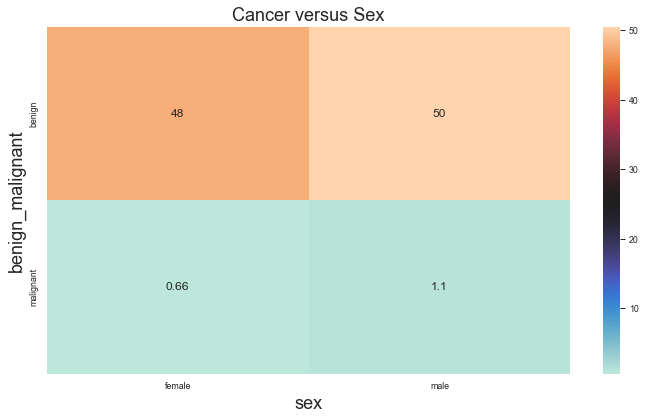

In [32]:
cancer_versus_sex = train.groupby(["benign_malignant", "sex"]).size().unstack(level = 1) / len(train) * 100
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":20,"axes.labelsize":18})   

plt.figure(figsize = (10, 6))
sns.heatmap(cancer_versus_sex, annot=True, cmap="icefire", cbar=True)
plt.title("Cancer versus Sex", fontsize = 18)
plt.tight_layout()

From the above heatmap, we see that:
- There are about 3% more males than females in the dataset
- Males and females have a roughly equal chance of having a benign lesion
- Lesions in a man are twice as likely to be malignant than in females

## Age

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


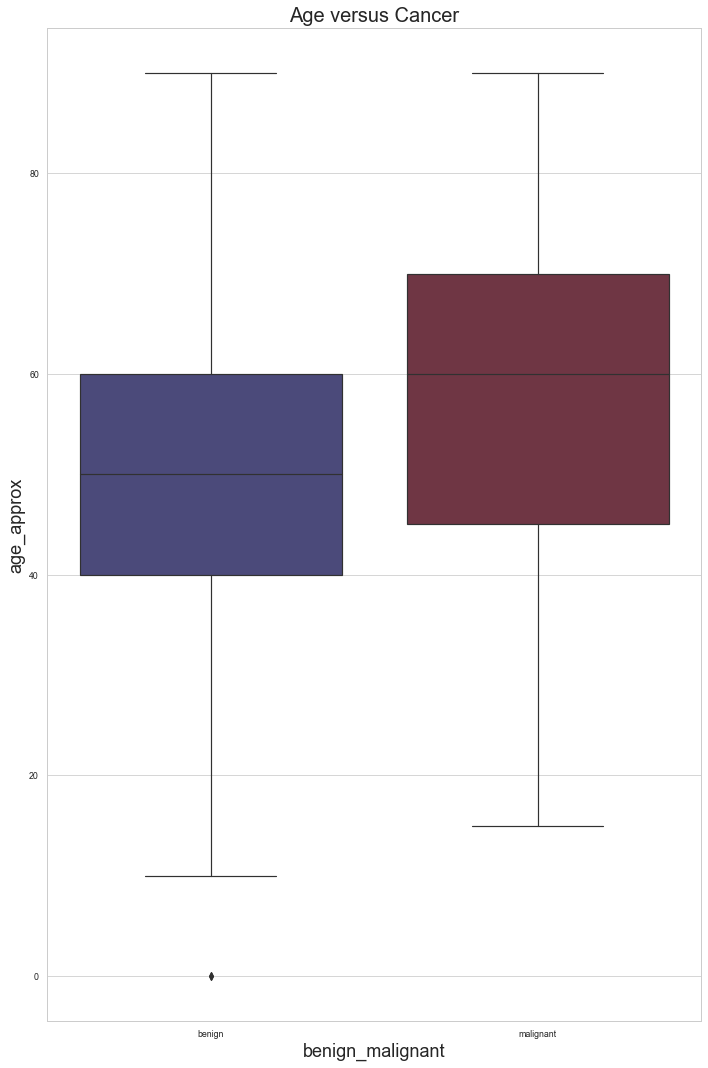

In [33]:
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":20,"axes.labelsize":18})   

plt.figure(figsize = (10, 15))
sns.boxplot(train["benign_malignant"], train["age_approx"], palette="icefire")
plt.title("Age versus Cancer")
plt.tight_layout()

Text(0.5, 1.0, 'Probabilistic Age Distribution')

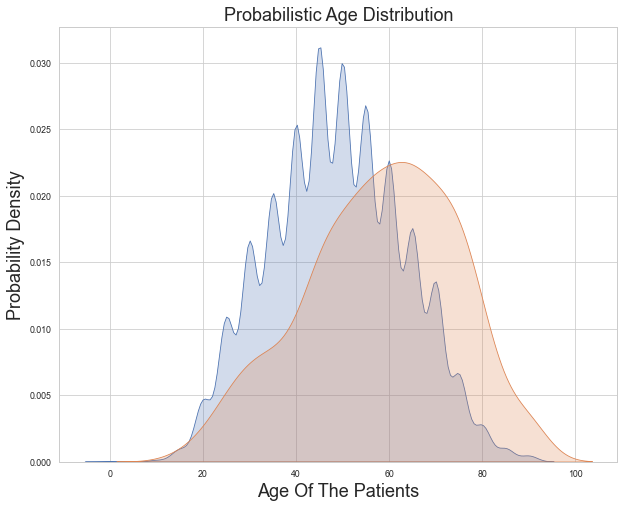

In [34]:
train_ages_benign = train.loc[train["target"] == 0, "age_approx"]
train_ages_malignant = train.loc[train["target"] == 1 , "age_approx"]

plt.figure(figsize = (10, 8))
sns.kdeplot(train_ages_benign, label = "Benign", shade = True, legend = True, cbar = True)
sns.kdeplot(train_ages_malignant, label = "Malignant", shade = True, legend = True, cbar = True)
plt.grid(True)
plt.xlabel("Age Of The Patients", fontsize = 18)
plt.ylabel("Probability Density", fontsize = 18)
plt.grid(which = "minor", axis = "both")
plt.title("Probabilistic Age Distribution", fontsize = 18)

Here, it can be seen that malignant lesions are generally found in those above ~50 while there is plenty of variance in benign cases.

## Location

In [35]:
print("--Training--")
print(train["anatom_site_general_challenge"].unique())
print(train["anatom_site_general_challenge"].value_counts())

print("\n\n")

print("--Testing--")
print(test["anatom_site_general_challenge"].unique())
print(test["anatom_site_general_challenge"].value_counts())

--Training--
['head/neck' 'upper extremity' 'lower extremity' 'torso' nan 'palms/soles'
 'oral/genital']
torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64



--Testing--
[nan 'lower extremity' 'torso' 'upper extremity' 'head/neck' 'palms/soles'
 'oral/genital']
torso              5847
lower extremity    2501
upper extremity    1573
head/neck           576
palms/soles         108
oral/genital         26
Name: anatom_site_general_challenge, dtype: int64


A vast majority of lesions are found on the torso and then the lower extremities, followed by the other locations. However, it does not influence the likelihood of melanoma but is still a good metric to collect for research purposes.

## Image Analysis

Samples with Melanoma


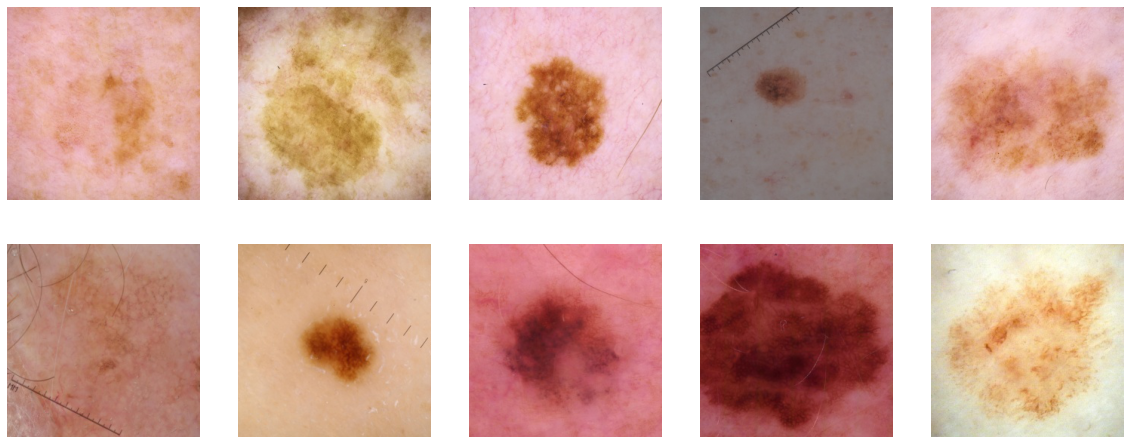

Samples without Melanoma


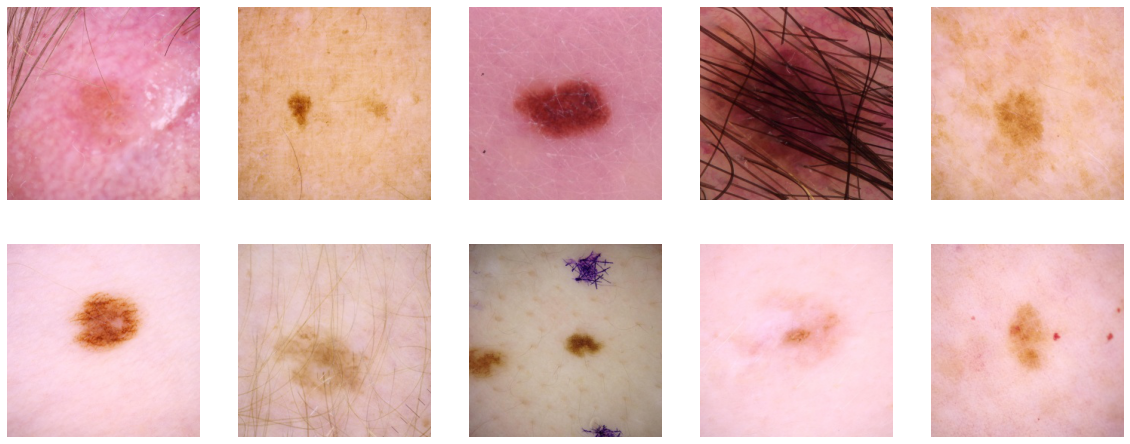

In [36]:
df = train
print("Samples with Melanoma")
imgs = df[df.target==1]['image_name'].values
_, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for f_name, ax in zip(imgs[:10],axs):
    img = Image.open(path/f'train/{f_name}.jpg')
    ax.imshow(img)
    ax.axis('off')
plt.show()

print("Samples without Melanoma")
imgs = df[df.target==0]['image_name'].values
_, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()
for f_name, ax in zip(imgs[:10],axs):
    img = Image.open(path/f'train/{f_name}.jpg')
    ax.imshow(img)
    ax.axis('off')    
plt.show()

Visually, the differences seem to be in the shape of the lesion:
- If benign, it is usually round/regular in shape
- If malignant, it is jagged and irregular in shape

## Missing Data

Text(0.5, 1.0, 'Sex')

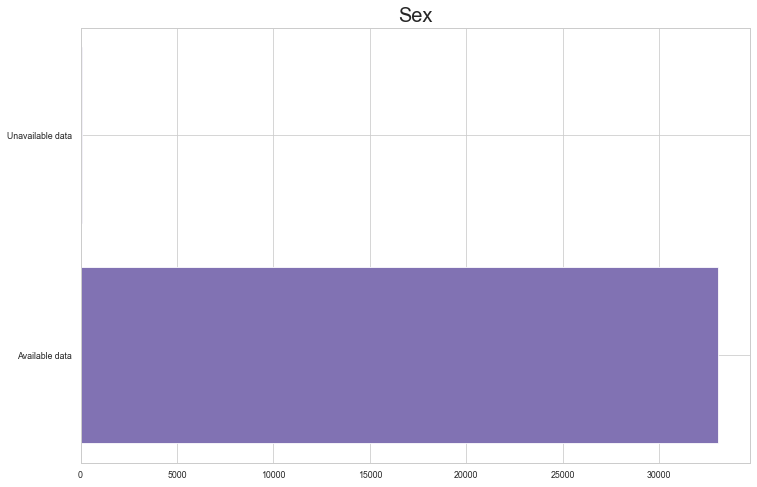

In [37]:
missing = len(train[train["sex"].isna() == True])
available = len(train[train["sex"].isna() == False])

x = ["Available data", "Unavailable data"]
y = [available, missing]

plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.barh(x, y, color = "m")
plt.grid(True)
plt.title("Sex")

Text(0.5, 1.0, 'Age')

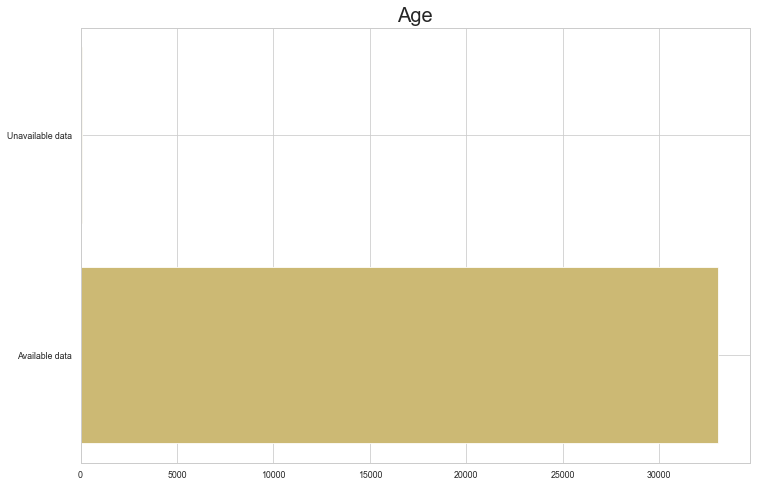

In [38]:
missing =  len(train[train["age_approx"].isna() == True]) 
available = len(train[train["age_approx"].isna() == False]) 


x = ["Available data", "Unavailable data"]
y = [available, missing]

plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.barh(x, y, color = "y")
plt.grid(True)
plt.title("Age")

# Conclusion
The main factors that influence the probability of melanoma (and should thus be used in the model) are:
- Age
- Shape of Lesion
- Location on the body
- Gender (to a lesser extent)

Though it may not be evident in the graphs above, there are about 70 rows which are missing both age and gender. Since they are so insignificant, it would likely be a good idea to delete the rows with missing parameters.